In [1]:
import lamination_station
import os
import anndata
import scanpy as sc
import seaborn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import networkx as nx
# import cuml
import torch
if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/lamination_station/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


# Dataset

Should be a pandas table with an x column, y column and a classification

- Removing glia or cell types not expected to define your structures is highly recommended

- Orienting your sections isn't necessary

- BUT-Make sure your sections are not overlapping in your x,y space
  - You can just add a different arbitrary large number to x or y for each separate tissue section

In [9]:
x_col = 'center_x'
y_col = 'center_y'
taxon_level = 'WithinArea_cluster_Corr'

In [3]:
import h5py
with h5py.File('/home/matthew.schmitz/Matthew/data/cortex_data/callaway_macaque/spatial_sections_analyzed.h5ad') as f:
    df = anndata.io.read_elem(f['obs'])

In [10]:
cur_max = 0
for i in df['batch'].cat.categories:
    df.loc[df['batch']==i,'center_x_translated'] = df.loc[df['batch']==i,x_col] + cur_max
    cur_max += df.loc[df['batch']==i,x_col].max() + 100
        

In [11]:
x_col = 'center_x_translated'
y_col = 'center_y'

In [20]:
df = df.loc[(df['Class_Corr'] != 'non-neuronal')&~(df['WithinArea_subclass_Corr'] != 'Astro')]

In [3]:
# making my dataframe
# merged_adata = sc.read_h5ad('/home/matthew.schmitz/Matthew/data/cortex_data/callaway_macaque/spatial_sections_analyzed.h5ad')

# merged_adata.obs['consensus_cluster'] = merged_adata.obs['consensus_cluster_Hierarchical_AIBS_SpC_consensus'].astype('category')

# drg_cells = (merged_adata.obs[x_col]>32100) & (merged_adata.obs[y_col]<34000)
# merged_adata = merged_adata[(merged_adata.obs['avg_correlation.Hierarchical.Group_AIBS_SpC_consensus']>0.1)&~drg_cells& ((merged_adata.obs['Class']!='Non-Neurons')),:]#|merged_adata.obs['Subclass'].str.contains('Astro|Ependy'))

# gc = merged_adata.obs.loc[:,['Group','consensus_cluster']].drop_duplicates()
# gc = gc.loc[gc['Group'].str.contains('Astro|Ependy'),:]
# merged_adata.obs["consensus_cluster_astrofix"] = merged_adata.obs["consensus_cluster"].replace(dict(zip(gc['consensus_cluster'],gc['Group'])))

# df = merged_adata.obs
df.to_csv('/home/matthew.schmitz/Matthew/data/cortex_data/callaway_macaque/merfish_coords_classes.tsv',sep='\t')

/scratch/fast/1707761/ipykernel_1257600/688874619.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  merged_adata.obs["consensus_cluster_astrofix"] = merged_adata.obs["consensus_cluster"].replace(dict(zip(gc['consensus_cluster'],gc['Group'])))


In [4]:
# commented to keep categoricals
# df = pd.read_csv('/home/matthew.schmitz/Matthew/data/cortex_data/callaway_macaque/merfish_coords_classes.tsv',sep='\t',index_col=0)

In [21]:
df.loc[:,[x_col,y_col,taxon_level]] #This is what your starting data frame should look like

center_x_translated     center_y WithinArea_cluster_Corr
1338607175_1                860.854919   705.950073                 L5 IT_7
1338607175_2                882.725464   708.618286                 L6 CT_4
1338607175_6                950.633057   717.737244                 L5 IT_1
1338607175_7                973.846436   720.342407                 L6 CT_2
1338607175_8               1005.411926   722.595947            Lamp5 Lhx6_1
...                                ...          ...                     ...
1338611863_132531         39957.523438  8680.807617            Lamp5 Lhx6_1
1338611863_132535         39936.957031  8695.145508                 L6 CT_4
1338611863_132544         39988.105469  8714.106445                 L6 CT_2
1338611863_132609         35381.566406  8997.189453                 Lamp5_3
1338611863_132610         35418.781250  8992.652344                 Pvalb_3

[383229 rows x 3 columns]

In [22]:

df_grads,cell_types,gradients,comp_vectors_pca,comp_vectors,neighbor_counts,neighbor_type_vecs = lamination_station.pp.calculate_comp_grads(
    df,
    x_col,
    y_col,
    celltype_col=taxon_level,
    near_k=30,far_k=60,
    near_quantile=0.9,far_quantile=0.9, # Uncomment this block if you have QC gradients leading to differences in detected cell density
    use_cuda=True,grad_clip=0.9
)

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/lamination_station/src/lamination_station/preprocessing.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[celltype_col] = df[celltype_col].astype('category')
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/lamination_station/src/lamination_station/preprocessing.py:201: RuntimeWarning: divide by zero encountered in divide
  np.minimum(1.0, threshold/norms),


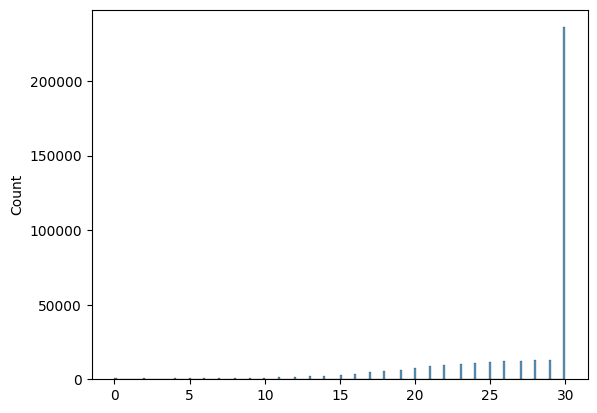

In [23]:
# #Uncomment this block if you have QC gradients leading to differences in detected cell density
seaborn.histplot(neighbor_counts.sum(1))
plt.show()
counts_over_thresh = neighbor_counts.sum(1)>10 #Keep cells with more than 10 neighbors within threshold
df_grads,cell_types,gradients,comp_vectors_pca,comp_vectors,neighbor_counts,neighbor_type_vecs = df_grads.loc[counts_over_thresh,:],cell_types[counts_over_thresh],gradients[counts_over_thresh],comp_vectors_pca[counts_over_thresh],comp_vectors[counts_over_thresh],neighbor_counts.loc[counts_over_thresh],neighbor_type_vecs.loc[counts_over_thresh]

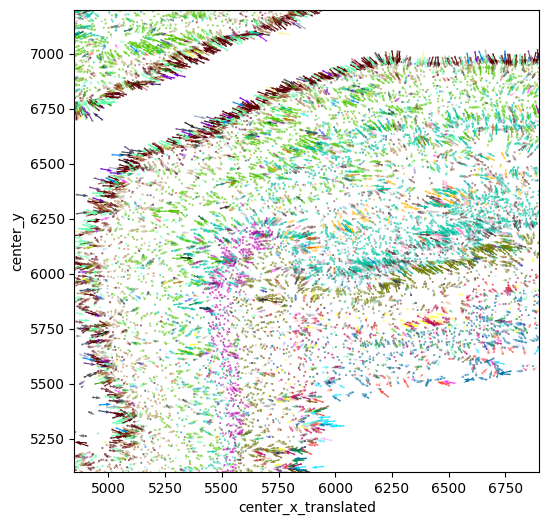

In [26]:
# Just plotting arrows
xlim = (4850,6900) # You'll need to pick your own coords
ylim = (5100,7200)
lamination_station.pl.plot_gradient_arrows(df_grads,gradients,'WithinArea_cluster_Corr',x_col,y_col,xlim,ylim,scale=0.004)

Epoch: 100%|██████████| 10/10 [03:04<00:00, 18.48s/it]


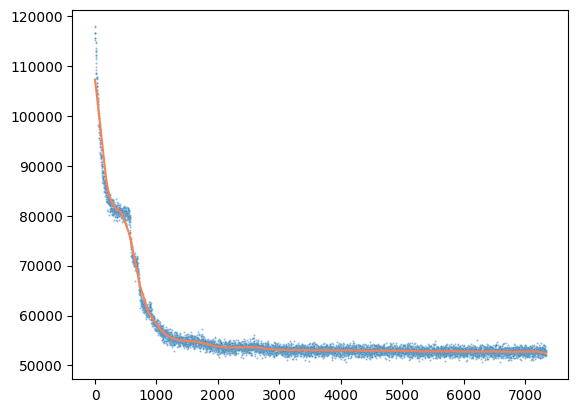

In [39]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

out,struct_logits,struct_comp,losses = lamination_station.model.run_model(
    df_grads,
    cell_types,
    neighbor_counts,
    gradients,
    neighbor_type_vecs,
    LATENT_DIM = 2,
    NUM_STRUCTURES = 30, # might need to play with this, pick a number more than your expected structures
    num_epochs=15,
    lr_steps = [1e-2,1e-3,1e-4],
    batch_size = 1024,
    STRUCT_SCALE_SCALE = 1., # Penalize broadness structure definitions
    OBS_FAMILY = "poisson",
    STRUCT_LOC_PRIOR_SCALE = 5., #lower penalizes cluster redundancy more
    LOSS_SCALE = 1., #loss scalar multiplier (only use if loss is crazy big/small)
    HIDDEN_DIM = 512, #Encoder/decoder dim
    HIDDEN_DIM_CLASSIFIER = 128, # classifier dim
    device = device
)

lamination_station.pl.plot_loss(losses)

In [40]:
import pyro
pyro.param('theta_b')

tensor([[100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]],
       device='cuda:0', requires_grad=True)

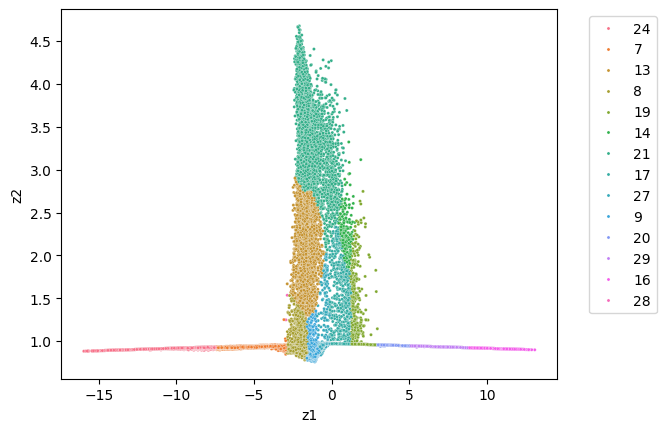

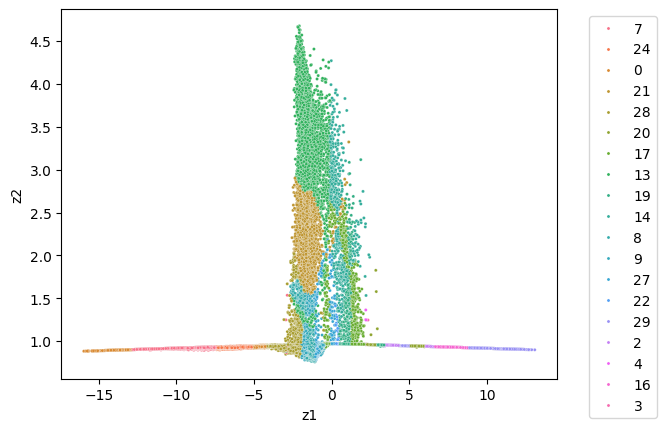

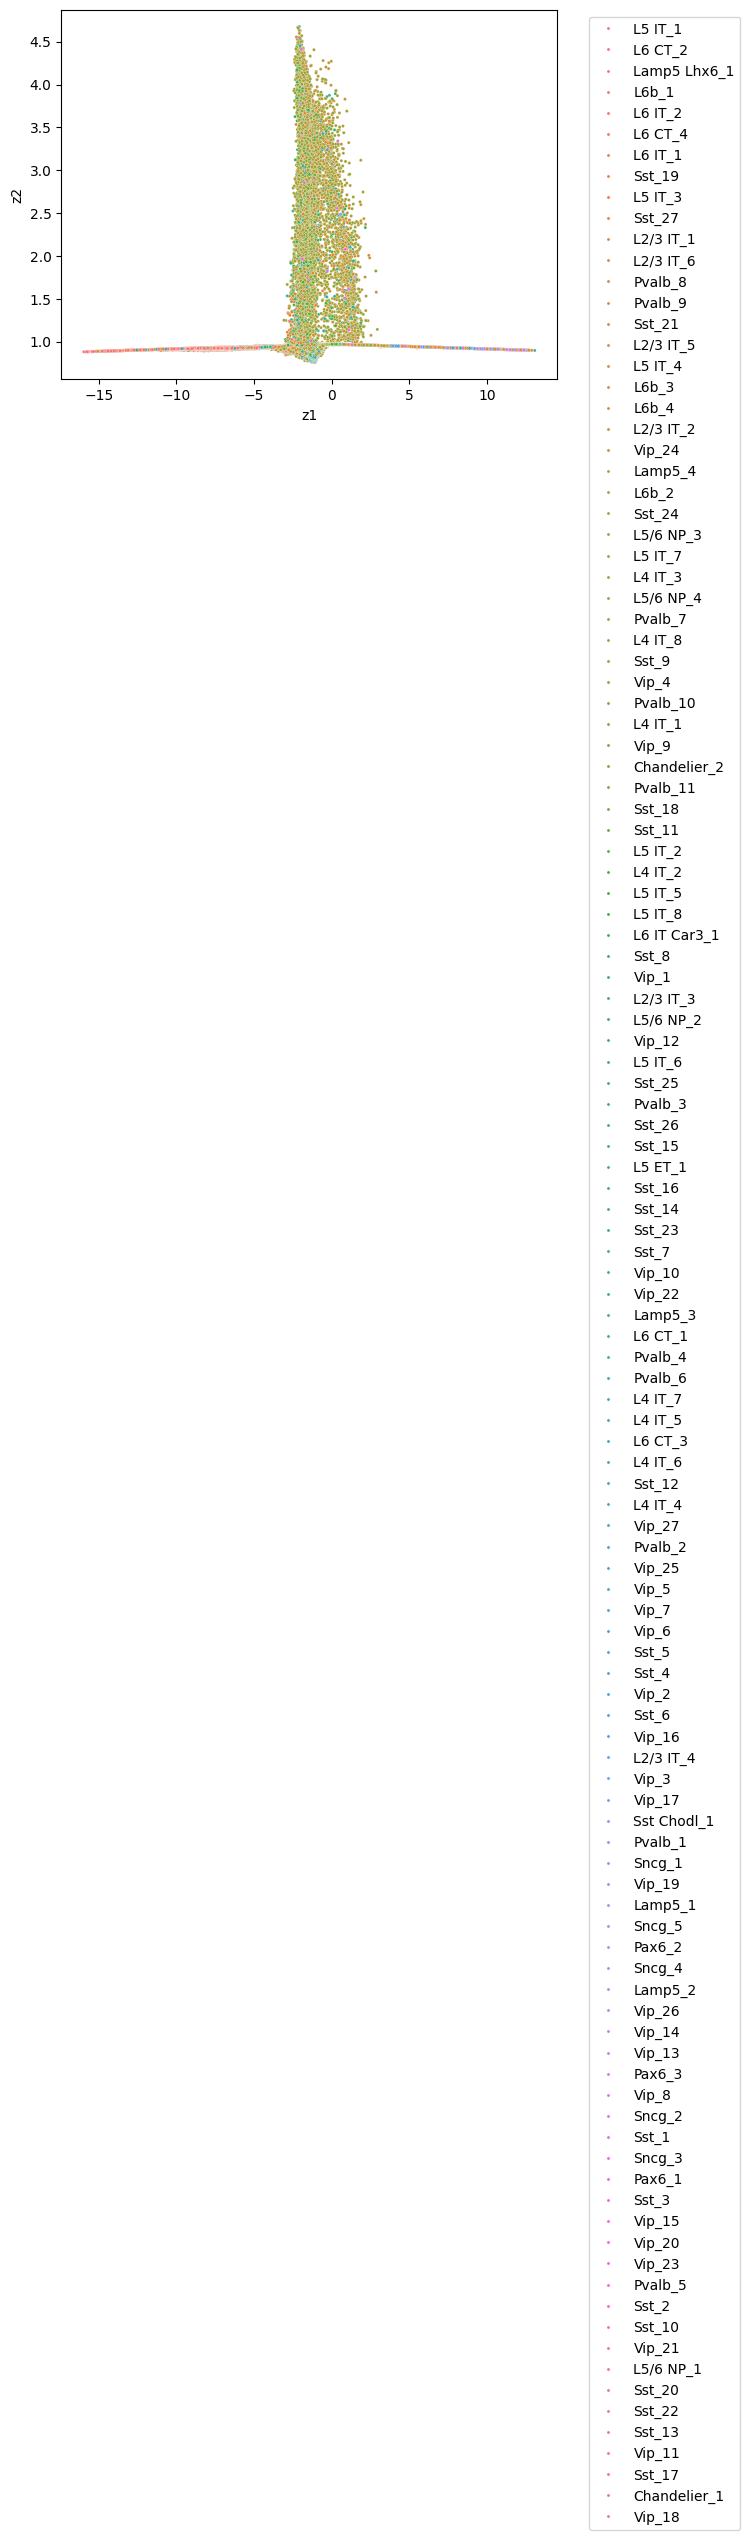

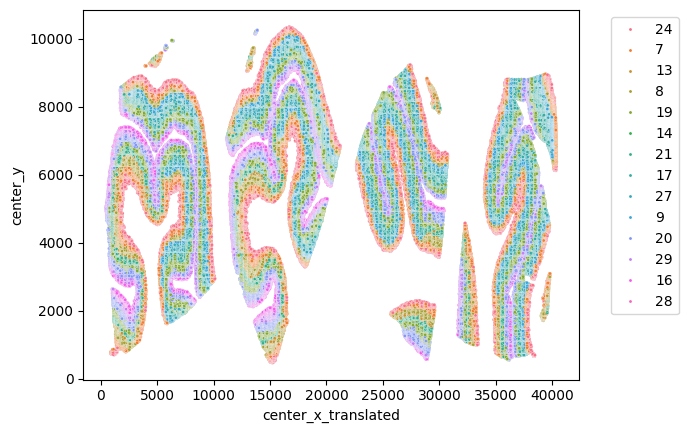

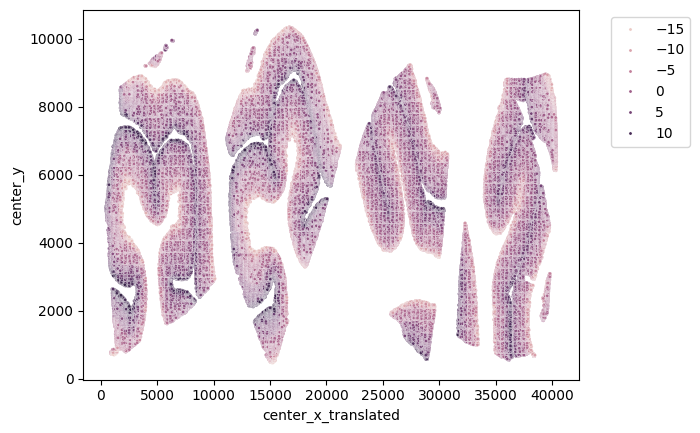

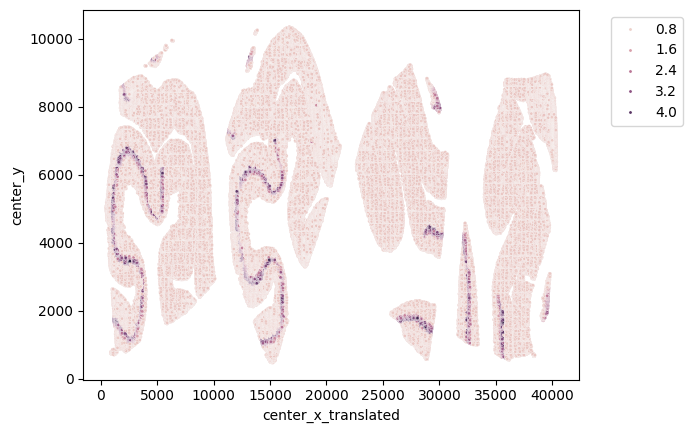

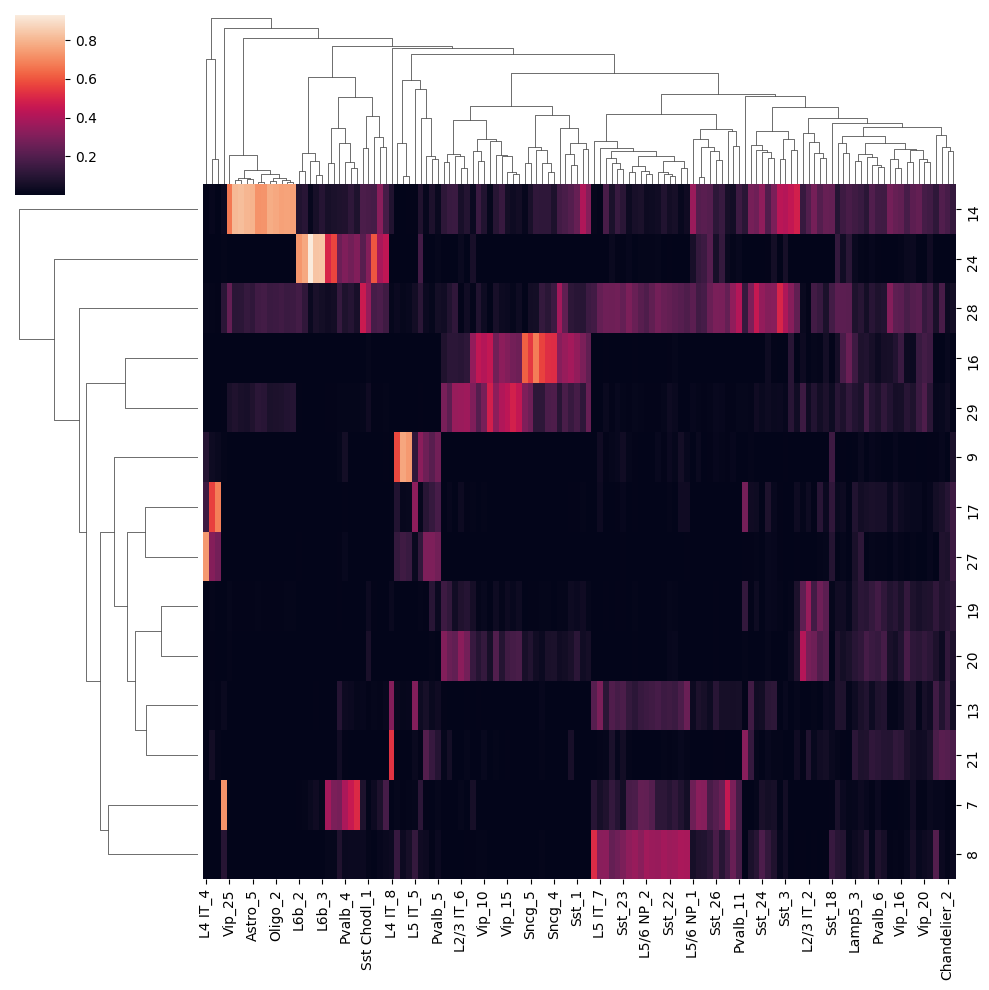

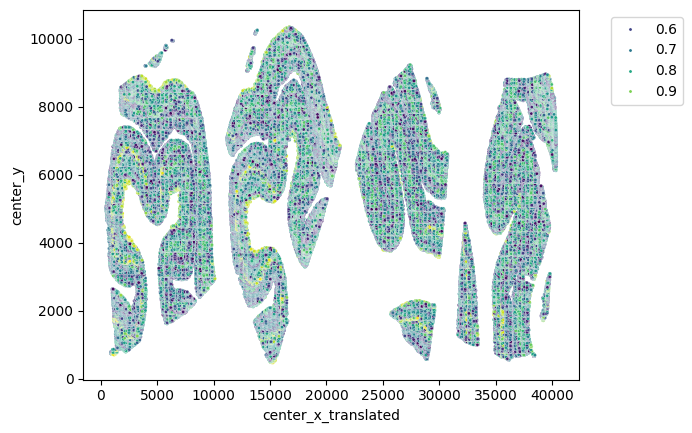

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/lamination_station/src/lamination_station/plotting.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


(<Axes: xlabel='x_graph', ylabel='y_graph'>,
 <Axes: xlabel='x_graph', ylabel='y_graph'>)

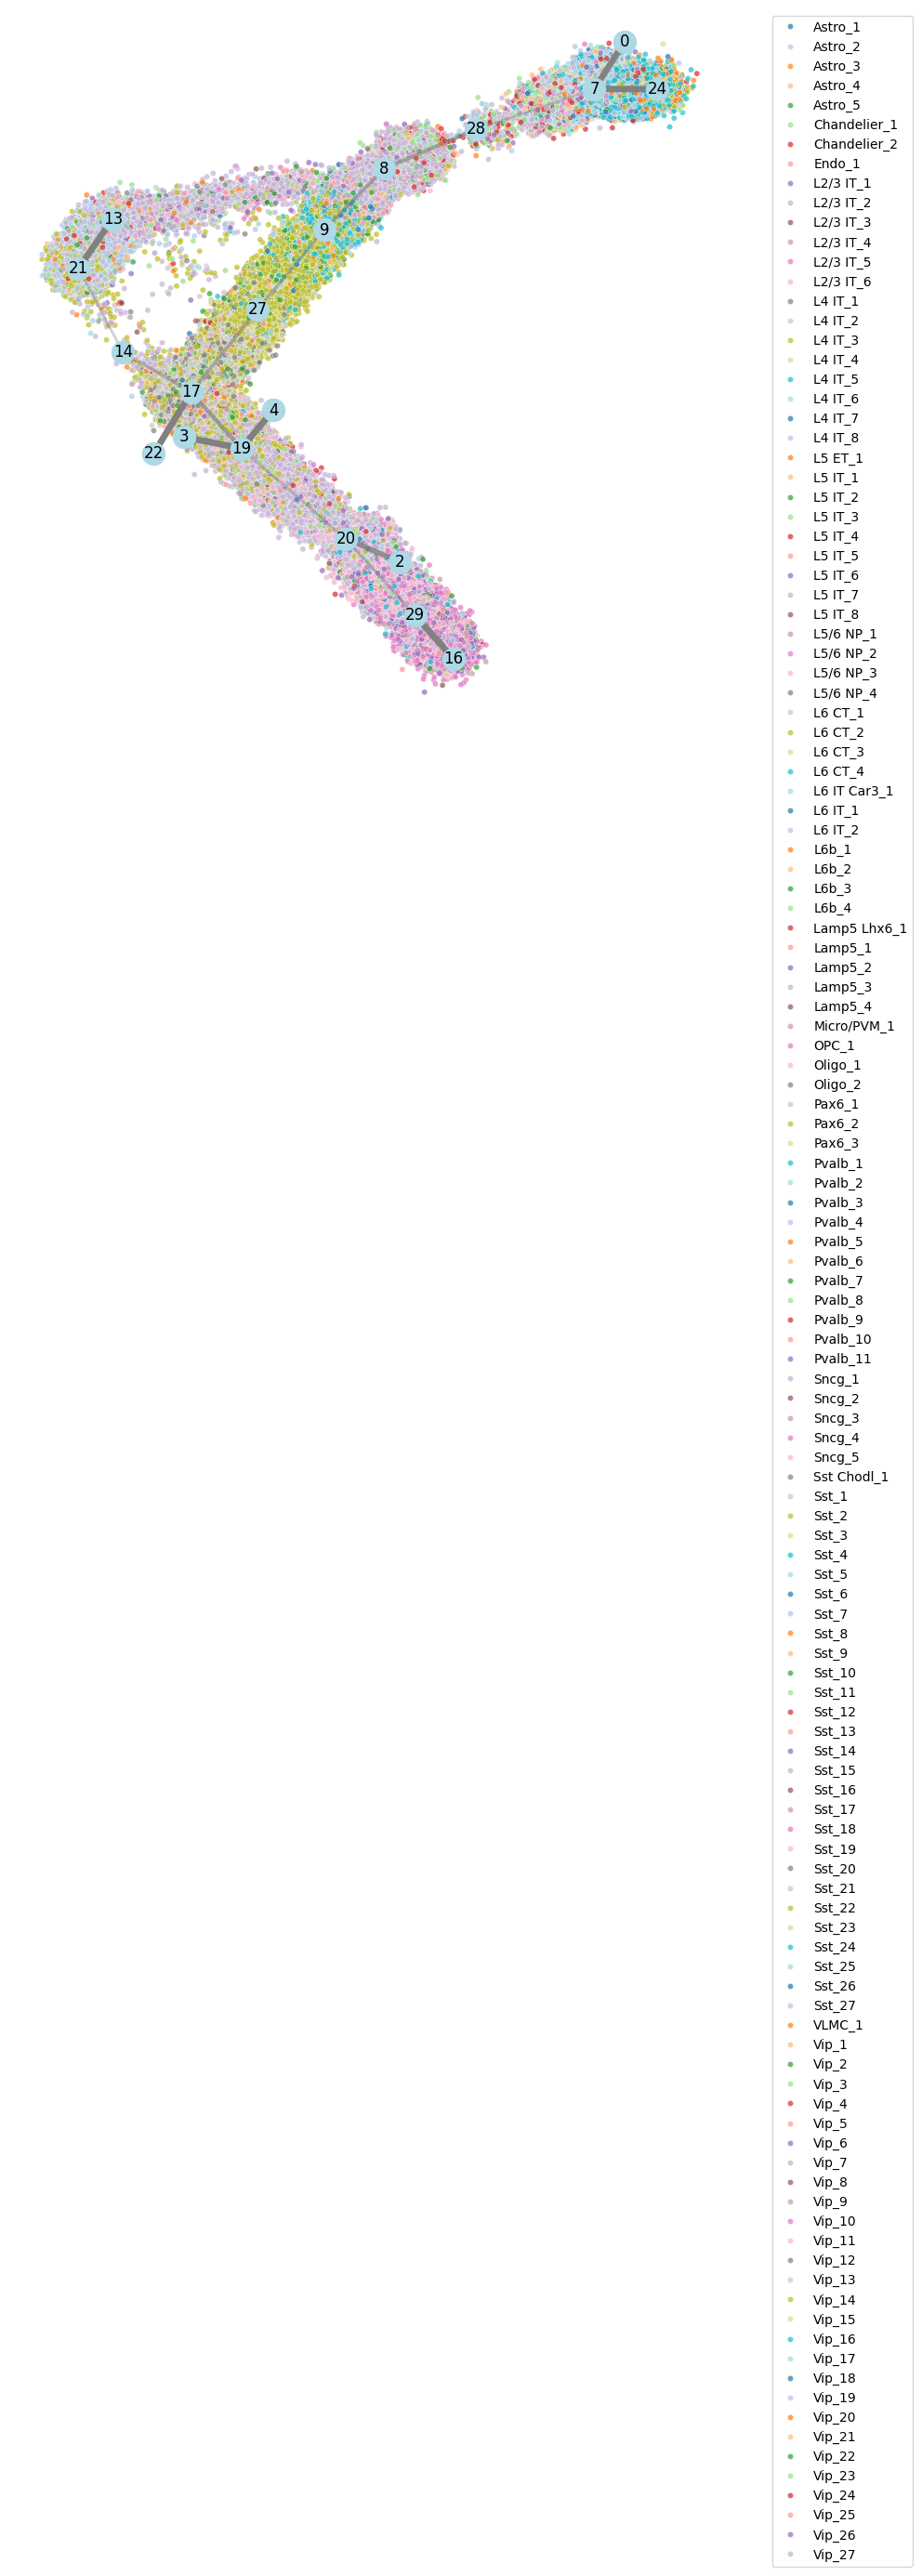

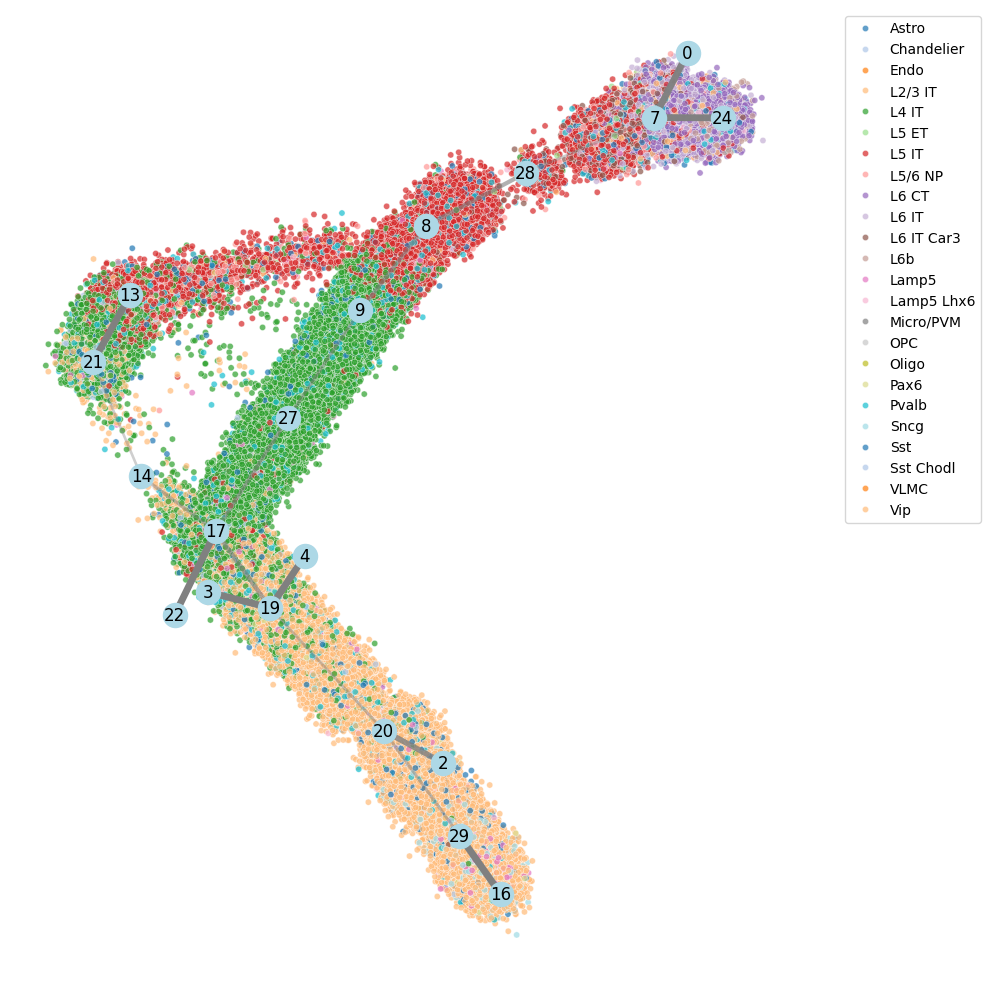

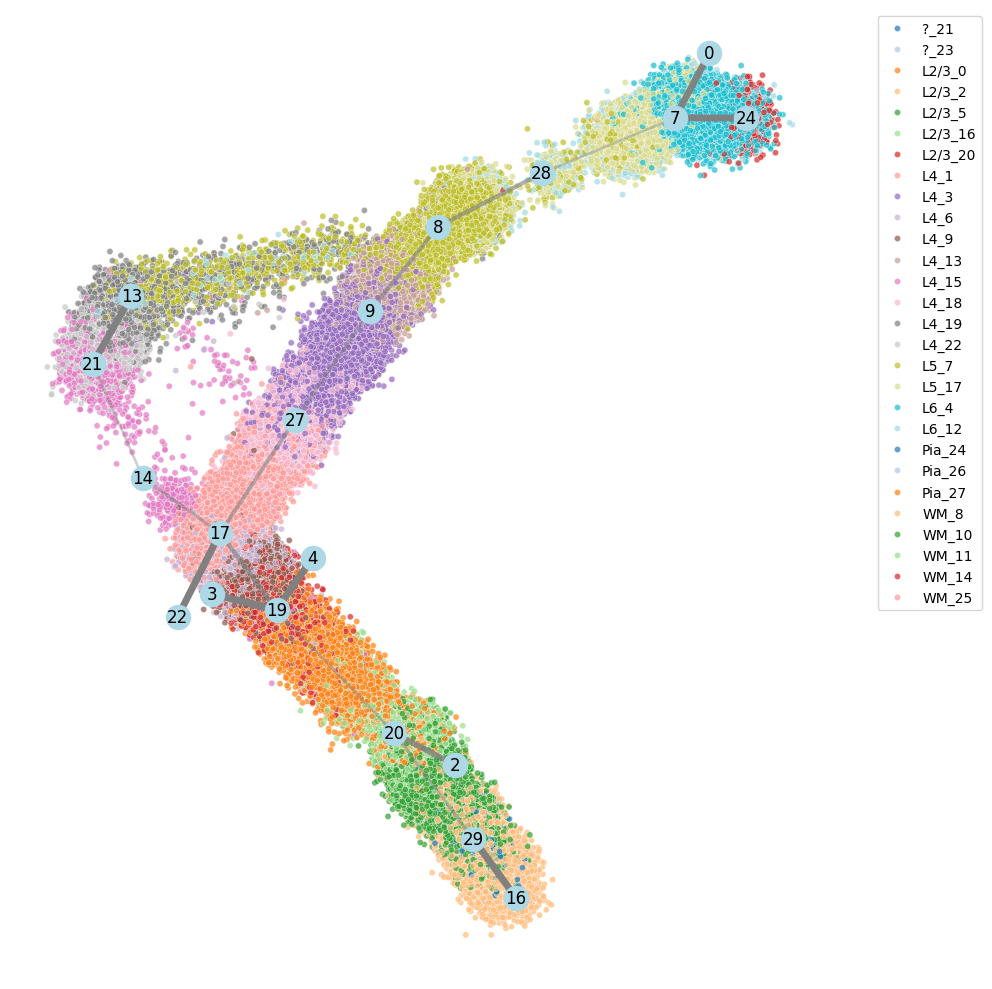

In [41]:
seaborn.scatterplot(x=out['z1'], y=out['z2'], hue=out['structure_pred1'].astype(str), s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out['z1'], y=out['z2'], hue=out['structure_pred2'].astype(str), s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out['z1'], y=out['z2'], hue=out[taxon_level].astype(str), s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out[x_col], y=out[y_col], hue=out['structure_pred1'].astype(str), s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out[x_col], y=out[y_col], hue=out['z1'], s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out[x_col], y=out[y_col], hue=out['z2'], s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


try:
    comp_df = pd.DataFrame(struct_comp,columns=df_grads[taxon_level].cat.categories.sort_values()).loc[out['structure_pred1'].cat.categories.astype(int)]
    seaborn.clustermap(comp_df/comp_df.sum(0))
    plt.show()
except:
    print('flat comp_df')

seaborn.scatterplot(
    x=out[x_col],
    y=out[y_col],
    hue=out["phi"],
    s=5.,
    palette="viridis"
)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
# cb = plt.colorbar()
# cb.set_label("phi = p1/(p1+p2)")
plt.show()

# build & draw co-occurrence graph
# build sets of samples where each struct appears in top2
top2_arr = np.stack([out['structure_pred1'].astype(int),out['structure_pred2'].astype(int)],axis=-1)
N, S = top2_arr.shape[0], struct_logits.shape[1]
sets = {s: set(np.where((top2_arr == s).any(axis=1))[0]) for s in range(S)}

G = nx.Graph()
G.add_nodes_from(range(S))
for u in range(S):
    for v in range(u+1, S):
        A, B = sets[u], sets[v]
        if not A or not B:
            continue
        # overlap coefficient
        w = len(A & B) / min(len(A), len(B)) # len(A | B)
        if w > 0:
            G.add_edge(u, v, weight=w)

lamination_station.pl.plot_cells_on_structure_graph(
    out=out,
    G=G,
    jitter=0.03,      # e.g. 0.01–0.1
    cell_size=20,
    cell_alpha=0.7,
    color_col=taxon_level,
    figsize=(10,10),
    spring_k=0.1,     # tune for spacing
    seed=42
)
lamination_station.pl.plot_cells_on_structure_graph(
    out=out,
    G=G,
    jitter=0.03,      # e.g. 0.01–0.1
    cell_size=20,
    cell_alpha=0.7,
    color_col='WithinArea_subclass_Corr',
    figsize=(10,10),
    spring_k=0.1,     # tune for spacing
    seed=42
)

lamination_station.pl.plot_cells_on_structure_graph(
    out=out,
    G=G,
    jitter=0.03,      # e.g. 0.01–0.1
    cell_size=20,
    cell_alpha=0.7,
    color_col='merged_layer_cluster',
    figsize=(10,10),
    spring_k=0.1,     # tune for spacing
    seed=42
)



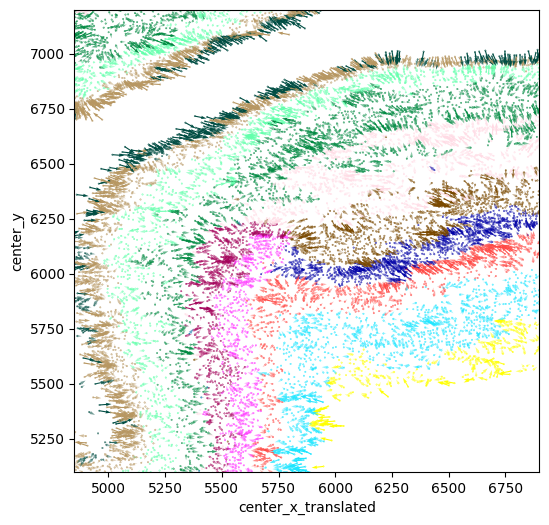

In [45]:
xlim = (4850,6900) # You'll need to pick your own coords
ylim = (5100,7200)
lamination_station.pl.plot_gradient_arrows(out,gradients,'structure_pred1',x_col,y_col,xlim,ylim,scale=0.004)

# Assigning depth on graph

The walks can sometimes be finicky... worst case you might have to put the nodes into a manual order

In [46]:
import numpy as np
import networkx as nx
import pandas as pd

def _node_diffusion_shortest_path(G, source, weight='weight'):
    # 1) get weighted shortest‐path lengths
    dists = nx.single_source_dijkstra_path_length(G, source, weight=weight)
    if not dists:
        # only source exists
        return {n: (1.0 if n == source else 0.0) for n in G.nodes()}
    max_d = max(dists.values())
    # 2) invert+normalize to [0,1]
    return {
        n: (1.0 - dists.get(n, np.inf) / max_d) if np.isfinite(dists.get(n, np.inf)) else 0.0
        for n in G.nodes()
    }

def _node_diffusion_pagerank(G, source, alpha=0.85, weight='weight'):
    # 1) set up personalization vector
    pers = {n: 1.0 if n == source else 0.0 for n in G.nodes()}
    # 2) run PPR
    pr = nx.pagerank(G, alpha=alpha, personalization=pers, weight=weight)
    vals = np.fromiter(pr.values(), float)
    lo, hi = vals.min(), vals.max()
    # 3) normalize into [0,1]
    if hi > lo:
        return {n: (v - lo) / (hi - lo) for n, v in pr.items()}
    else:
        return {n: 0.0 for n in pr}

def compute_cell_diffusion(
    out: pd.DataFrame,
    G: nx.Graph,
    source_node: int,
    method: str = 'pagerank',
    **diff_kwargs
) -> pd.DataFrame:
    """
    Returns a copy of `out` with a new column `diffusion` in [0,1].

    Parameters
    ----------
    out : DataFrame
        Must have 'structure_pred1', 'structure_pred2', 'phi' columns.
    G : Graph
        Full structure‐graph with numeric node IDs.
    source_node : int
        Node in G from which to diffuse.
    method : {'shortest_path','pagerank'}
        Which node‐diffusion to use.
    diff_kwargs :
        Passed to the underlying diffusion function:
          - for shortest_path: weight='weight'
          - for pagerank: alpha=0.85, weight='weight'
    """
    # 1) compute diffusion on graph nodes
    if method == 'shortest_path':
        node_scores = _node_diffusion_shortest_path(G, source_node, **diff_kwargs)
    elif method == 'pagerank':
        node_scores = _node_diffusion_pagerank(G, source_node, **diff_kwargs)
    else:
        raise ValueError(f"Unknown method {method!r}")

    # 2) map scores to each end of the predicted‐edge
    print(node_scores)
    d1 = out['structure_pred1'].astype(int).replace(node_scores).fillna(0.0)
    d2 = out['structure_pred2'].astype(int).replace(node_scores).fillna(0.0)

    # 3) interpolate along phi
    df = out.copy()
    df['diffusion'] = df['phi'] * d1 + (1 - df['phi']) * d2
    return df

# ── Example ──
# Assuming your `out` already exists and G was built as before:
out = compute_cell_diffusion(
    out, G,
    source_node=16,         # whichever structure‐node you want as source
    method='shortest_path',     # or 'pagerank'
)


{0: 0.006153321091086461, 1: 0.0, 2: 0.6519873916742209, 3: 0.16410005101654812, 4: 0.16410005101654812, 5: 0.0, 6: 0.0, 7: 0.2874892355883293, 8: 0.2896673924416828, 9: 0.3010632728822491, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.3022992876069567, 14: 0.4130666953400759, 15: 0.0, 16: 1.0, 17: 0.3024492803194151, 18: 0.0, 19: 0.4560537418419798, 20: 0.5775165458972953, 21: 0.3030915013727047, 22: 0.010495589493983548, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.30301810468090007, 28: 0.3029811637147374, 29: 0.7080463091745683}


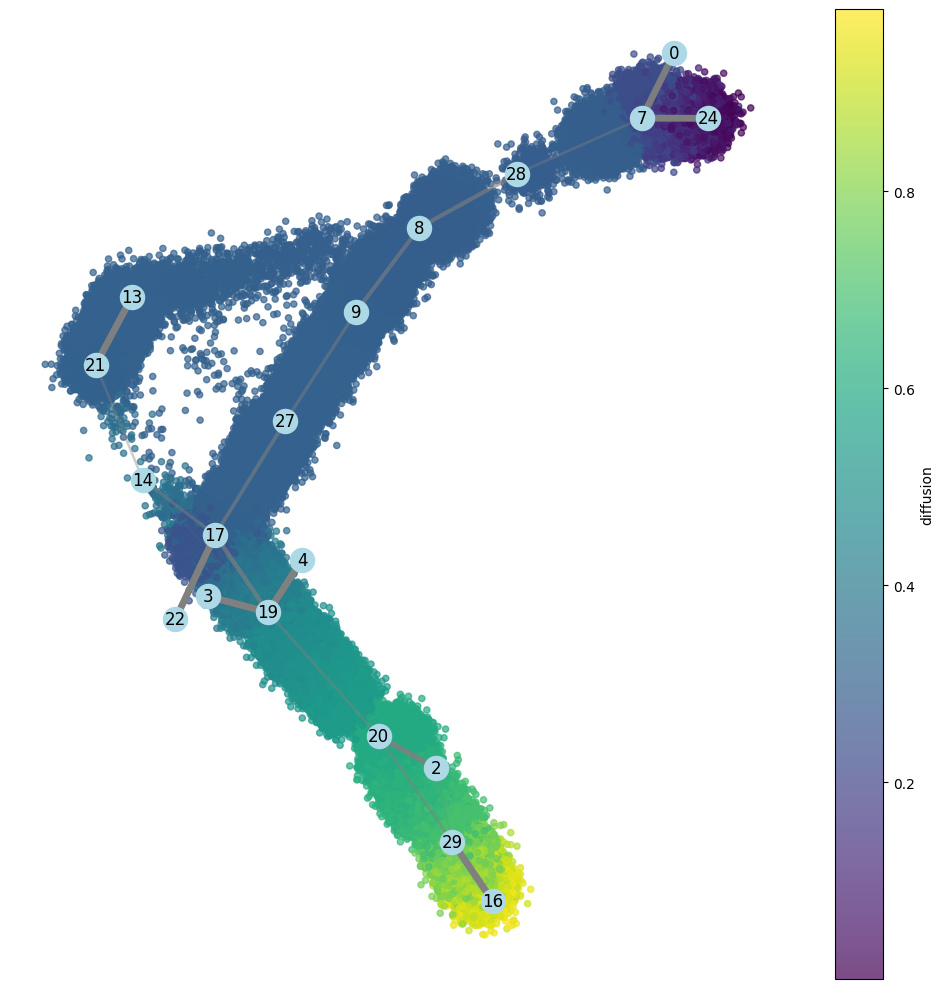

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/lamination_station/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


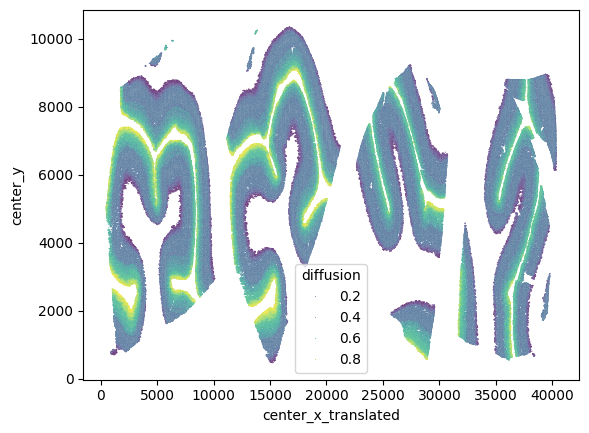

In [47]:
lamination_station.pl.plot_cells_on_structure_graph(
    out=out,
    G=G,
    jitter=0.03,      # e.g. 0.01–0.1
    cell_size=20,
    cell_alpha=0.7,
    color_col='diffusion',
    figsize=(10,10),
    spring_k=0.1,     # tune for spacing
    seed=42
)
plt.show()

seaborn.scatterplot(
    x=out[x_col],
    y=out[y_col],
    hue=out["diffusion"],
    s=0.5,
    palette="viridis"
)
plt.show()

In [48]:
q99 = np.quantile(out['diffusion'],0.99)
q01 = np.quantile(out['diffusion'],0.01)
out['diffusion_normalized'] = np.clip(out['diffusion'],q01,q99)
out['diffusion_normalized'] = (out['diffusion_normalized'] -out['diffusion_normalized'].min()) / (out['diffusion_normalized'].max()-out['diffusion_normalized'].min())

<Axes: xlabel='diffusion', ylabel='Count'>

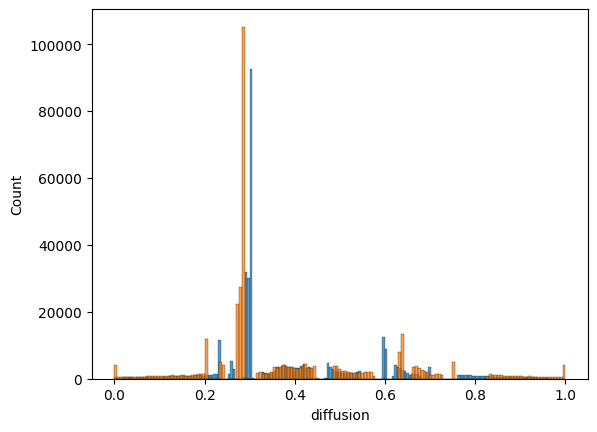

In [49]:
seaborn.histplot(out['diffusion'])
seaborn.histplot(out['diffusion_normalized'])

In [ ]:
# Example ridgeplot code, you'll need to modify significantly and make your own color dict
color_dict = dict(zip(merged_adata.obs['Group'].cat.categories,merged_adata.uns['Group_colors']))
seaborn.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
groups = out['Group'].unique()
pal = seaborn.cubehelix_palette(len(groups), rot=-.25, light=.7)
unique_groups = out['Group'].cat.categories.tolist()
# if you want the rows in the same order as your dict:
row_order = [g for g in color_dict.keys() if g in unique_groups]

# build a palette mapping just those groups
palette = { g: color_dict[g] for g in row_order }



g = seaborn.FacetGrid(
    out,
    row="Group",
    hue="Group",
    aspect=15,
    height=0.5,
    palette=palette
)

g.map(
    seaborn.kdeplot,
    "diffusion_normalized",
    bw_adjust=0.5,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5
)
g.map(
    seaborn.kdeplot,
    "diffusion_normalized",
    clip_on=False,
    color="w",
    lw=2,
    bw_adjust=0.5
)
g.refline(
    y=0,
    linewidth=2,
    linestyle="-",
    color=None,
    clip_on=False
)

def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes
    )

g.map(label, "diffusion")

# overlap the plots
g.figure.subplots_adjust(hspace=-0.25)

# clean up
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.xlim((-.45,1.))
plt.show()


In [ ]:
out['consensus_cluster_group'] = out['Group'].astype(str) +'__'+ out['consensus_cluster'].astype(str)
out['consensus_cluster_group'] = out['consensus_cluster_group'].astype('category')
vcs = out['consensus_cluster_group'].value_counts()
sub_out = out.loc[out['consensus_cluster_group'].isin(vcs.index[vcs>20])]

cat = 'consensus_cluster_group'

color_dict = dict(zip(merged_adata.obs['Group'].cat.categories,merged_adata.uns['Group_colors']))
unique_cats = sub_out['consensus_cluster_group'].cat.categories.tolist()
unique_groups = sub_out['consensus_cluster_group'].cat.categories.str.split('__').str[0].tolist()
# if you want the rows in the same order as your dict:
row_order = unique_cats
row_order_groups = pd.Series(row_order).str.split('__').str[0].tolist()

# build a palette mapping just those groups
palette = { k: color_dict[g] for k,g in zip(row_order,row_order_groups)}

seaborn.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = seaborn.FacetGrid(
    sub_out,
    row=cat,
    hue=cat,
    aspect=15,
    height=0.5,
    palette=palette
)

g.map(
    seaborn.kdeplot,
    "diffusion_normalized",
    bw_adjust=0.5,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5
)
g.map(
    seaborn.kdeplot,
    "diffusion_normalized",
    clip_on=False,
    color="w",
    lw=2,
    bw_adjust=0.5
)
g.refline(
    y=0,
    linewidth=2,
    linestyle="-",
    color=None,
    clip_on=False
)

def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes
    )

g.map(label, "diffusion")

# overlap the plots
g.figure.subplots_adjust(hspace=-0.25)

# clean up
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()


In [ ]:
import pyro
pyro.param('theta_a')

In [ ]:
pyro.param('theta_b')